# Import Libraries


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt



---

#Load and Prepare CIFAR-10 Data
In this block, we load the CIFAR-10 dataset. For a convolutional autoencoder, we do not flatten the images, as the convolutional layers work directly with their 2D spatial structure. We normalize the pixel values to be in the range [0, 1] by dividing by 255. The final shape of our data will be `(num_samples, 32, 32, 3)`.

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



---


# Define the U-Net Style Autoencoder Architecture

This is the core of our improved model. We define a U-Net-style architecture, which is an encoder-decoder model enhanced with skip connections.

* Encoder: Progressively downsamples the image using `Conv2D` and `MaxPooling2D`
layers to capture features at different scales. The outputs of the Conv2D layers `(c1, c2)` are saved for later use in the decoder path.

* Bottleneck: This is the most compressed, latent-space representation of the image.

* Decoder: Progressively upsamples the feature maps using `Conv2DTranspose`, which is a learned upsampling layer.

* Skip Connections: At each upsampling step in the decoder, we use a `Concatenate` layer to merge the upsampled feature map with the corresponding high-resolution feature map from the encoder path. This crucial step allows the decoder to recover fine-grained spatial details that were lost during downsampling, leading to much sharper and more accurate reconstructions.



In [3]:
input_img = Input(shape=(32, 32, 3))

# Encoder
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
p2 = MaxPooling2D((2, 2))(c2)

# Bottleneck
b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

# Decoder
u1 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(b)
s1 = Concatenate()([u1, c2]) # Skip connection 1

u2 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(s1)
s2 = Concatenate()([u2, c1]) # Skip connection 2

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(s2)

autoencoder = Model(input_img, decoded)



---
# Define Callbacks and Compile the Model
To make our training process smarter and more efficient, we define two Keras callbacks and Finally, we create the Model instance and compile it, using `adam` as the optimizer and `mse` (Mean Squared Error) as the loss function, which is well-suited for image reconstruction tasks.


In [6]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │     73,792 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │     36,896 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 3) │      1,731 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,667 (803.39 KB)

 Trainable params: 205,667 (803.39 KB)

 Non-trainable params: 0 (0.00 B)



---

# Train the Model



In [7]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopper, reduce_lr]
               )

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0169 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0011 - val_loss: 6.7264e-04 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.5293e-04 - val_loss: 4.9666e-04 - learning_rate: 0.0010
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 4.8488e-04 - val_loss: 4.1797e-04 - learning_rate: 0.0010
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 4.1127e-04 - val_loss: 3.3386e-04 - learning_rate: 0.0010
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.4582e-04 - val_loss: 2.9288e-04 - learning_rate: 0.0010
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.1353e-04 - val_loss: 2.6357e-04 - learning_rate: 0.0010
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 2.8104e-04 - val_loss: 2.4618e-04 - learning_rate: 0.0010
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15m



---
# Plot Training History
This block visualizes the model's performance during training.


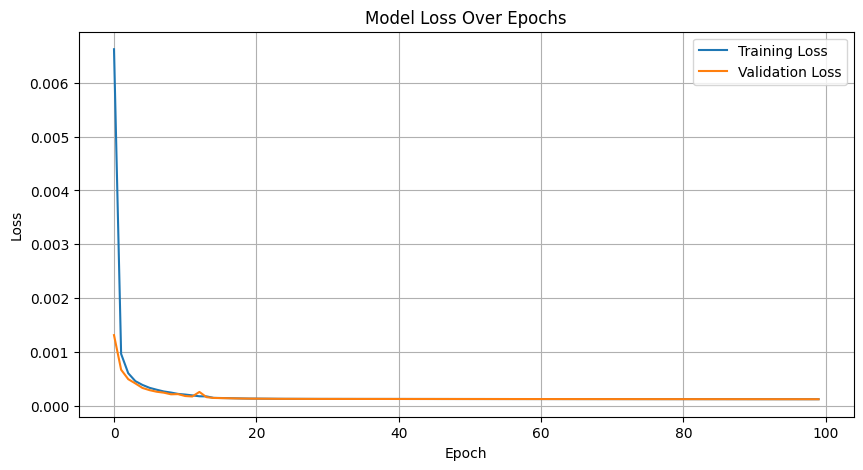

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()



---
# Visualize the Results
Finally, we use our trained autoencoder to reconstruct the images from the test set. We then plot the original images and their reconstructed versions side-by-side to visually inspect the quality of the reconstruction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


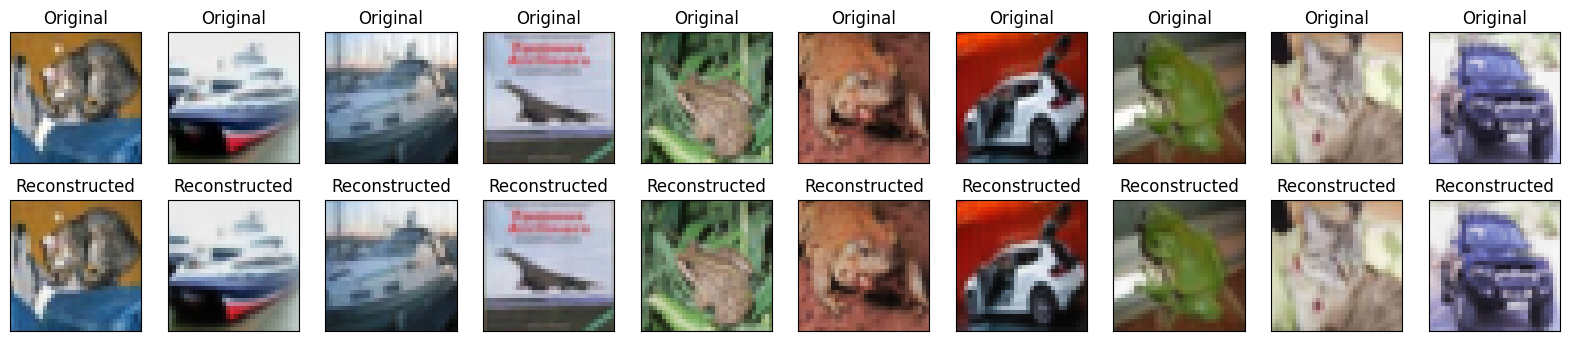

In [10]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()